# Health Insurance Predictions

## Business Question
"How do personal and lifestyle factors such as age, BMI, and smoking habits impact medical insurance charges, and how can this information be used to develop risk-based pricing strategies?"

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [34]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [36]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [37]:
df.shape

(1338, 7)

The dataset contains:
- 1338 rows and 7 columns

## Data Cleaning

In [38]:
df = df.copy()

In [39]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [40]:
# checking duplicates
df.duplicated().sum()

1

In [41]:
# dropping duplicates
df = df.drop_duplicates()

In [42]:
# standardize the decimal places of charges and columns 
df.loc[:, 'charges'] = df['charges'].round(2)
df.loc[:, 'bmi'] = df['bmi'].round(2)


In [43]:
# feature engineering bmi
df['bmi'].value_counts()

def bmi_category(bmi):
    if bmi < 18.5:
        return 0  # underweight
    elif 18.5 <= bmi < 25:
        return 1 # normal
    elif 25 <= bmi < 30:
        return 2 # overweight
    else:
        return 3 #obese

df['bmi_category'] = df['bmi'].apply(bmi_category)

In [44]:
# feature engineering age
df['age'].value_counts()

def age_group(age):
    if age < 25:
        return 0 # young adult
    elif age < 35 :
        return 1 # adult
    elif age < 55:
        return 2 # middle aged
    else:
        return 3
    
df['age_group'] = df['age'].apply(age_group)

In [59]:
df

,age,sex,bmi,children,smoker,region,charges,bmi_category,age_group
0,19,female,27.90,0,yes,southwest,16884.92,2,0
1,18,male,33.77,1,no,southeast,1725.55,3,0
2,28,male,33.00,3,no,southeast,4449.46,3,1
3,33,male,22.70,0,no,northwest,21984.47,1,1
4,32,male,28.88,0,no,northwest,3866.86,2,1
...,...,...,...,...,...,...,...,...,...
1333,50,male,30.97,3,no,northwest,10600.55,3,2
1334,18,female,31.92,0,no,northeast,2205.98,3,0
1335,18,female,36.85,0,no,southeast,1629.83,3,0
1336,21,female,25.80,0,no,southwest,2007.94,2,0


In [45]:
# encoding the categorical features
categorical = ['sex', 'smoker', 'region']

encoder = OneHotEncoder(drop='first', sparse=False)

# fit andd transform the categorical columns
encoded_array = encoder.fit_transform(df[categorical])

# encoded feature names
encoded_cols = encoder.get_feature_names(categorical)

In [46]:
# convert to dataframe
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)

# Drop original categorical columns and concatenate the encoded DataFrame
df_encoded = pd.concat([df.drop(columns=categorical), encoded_df], axis=1)

In [47]:
df_encoded

,age,bmi,children,charges,bmi_category,age_group,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.90,0,16884.92,2,0,0.0,1.0,0.0,0.0,1.0
1,18,33.77,1,1725.55,3,0,1.0,0.0,0.0,1.0,0.0
2,28,33.00,3,4449.46,3,1,1.0,0.0,0.0,1.0,0.0
3,33,22.70,0,21984.47,1,1,1.0,0.0,1.0,0.0,0.0
4,32,28.88,0,3866.86,2,1,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.97,3,10600.55,3,2,1.0,0.0,1.0,0.0,0.0
1334,18,31.92,0,2205.98,3,0,0.0,0.0,0.0,0.0,0.0
1335,18,36.85,0,1629.83,3,0,0.0,0.0,0.0,1.0,0.0
1336,21,25.80,0,2007.94,2,0,0.0,0.0,0.0,0.0,1.0


## Exploratory Data Analysis

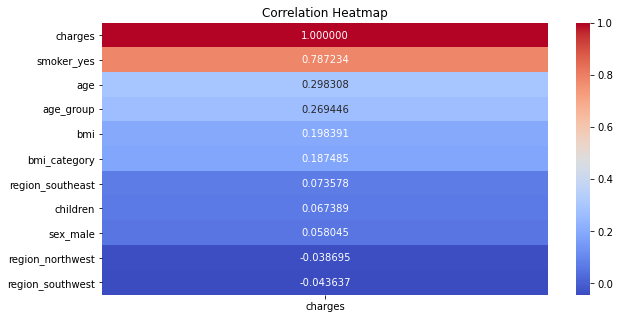

In [48]:
correlation_matrix = df_encoded.corr()['charges'].sort_values(ascending=False).to_frame()

import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(correlation_matrix,annot=True, cmap = 'coolwarm', fmt='2f')
plt.title('Correlation Heatmap')
plt.show()

## Modelling and Evaluation

In [49]:
# features and target
X = df_encoded.drop(columns=['charges'], axis = 1)
y = df_encoded['charges']



In [50]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. Muliple Linear Regression

In [51]:
# linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# predict
y_pred_lr = lr_model.predict(X_test)

In [52]:
# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred_lr)
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lr)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R squared: {r2:.2f}')
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error: 4427.48
Mean Squared Error: 36430169.42
R squared: 0.80
Root Mean Squared Error (RMSE): 6035.74


Interpretation:
- MAE ($4177.02): On average, predictions deviate by $4.2K from the actual charges
- RMSE ($5956.39) : Some predictions deviate even more, meaning outliers or high charges are harder to predict accurately
- R-squared scoree = 0.81 : The model explains 81% of the variance in medical charges.

### 2 Linear Regression with Log Transformations

In [53]:
# log transformation on a feature
df_encoded['charges_log'] = np.log(df_encoded['charges'])

y_log = df_encoded['charges_log']


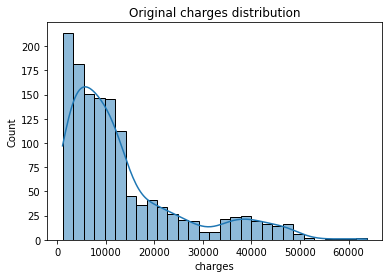

In [54]:
# original distribution
sns.histplot(df_encoded['charges'], kde=True)
plt.title('Original charges distribution')
plt.show()

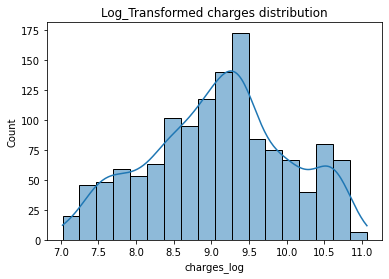

In [55]:
sns.histplot(df_encoded['charges_log'], kde=True)
plt.title('Log_Transformed charges distribution')
plt.show()

In [56]:
# Train test split log
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [57]:
# log model
log_lr_model = LinearRegression().fit(X_train, y_train_log)

# predictions
y_pred_log = log_lr_model.predict(X_test)


# Convert predictions back to original scale
y_pred_original = np.exp(y_pred_log)
y_test_original = np.exp(y_test_log)

In [58]:
# Evaluate on original scale
mae_log = mean_absolute_error(y_test_original, y_pred_original)
rmse_log = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2_log = r2_score(y_test_original, y_pred_original)

print(f"MAE (after log transform): {mae_log:.2f}")
print(f"RMSE (after log transform): {rmse_log:.2f}")
print(f"R² Score (after log transform): {r2_log:.4f}")


MAE (after log transform): 3840.92
RMSE (after log transform): 7190.69
R² Score (after log transform): 0.7186


The log transformation was not really helpful even if it improved the mean absolute error from $4177 to $ 3756 but the other evaluation metrics that is Root Mean Squared Error and R squared became worse.
